# MLND Capstone Project
This project is the final assignment of the data science nano degree course. The goal of the project is to develop a tool that can predict stock prices in future. To make it more interesting, instead of stocks, we will be working with cryptocurrencies. 
All the underlying information that will be used to train the model will be the same as the stock price information, so training the model on cryptocurrencies does not change the methodology or the outcome of the model. 


## Problem Statement:
Since the beginning of stock trading as we know it, traders have tried to make profits by picking stocks that will appreciate in value in short or long term. However, most people are not successful in predicting the future outcome of the market and fail to predict the price movements of their stocks. There are, however, a small fraction of traders who use a variety of methods to trade and generate income. 

Technical analysis is one of the most popular methods of predicting the future price movement of a stock/currency based on their past behavior. In technical analysis, traders can use a variety of different indicators which all provide some information about a certain aspect of the price movement, such as rate of change of price, magnitude of price change, average of losses and gains within a certain period of time, etc. 

While the abundance of different technical indicators has enabled traders to choose one or more indicators that suits their trading style best, people often find it overwhelming when it comes to defining a strategy based on multiple indicators. Machine learning can be a useful tool to define a strategy based on multiple indicators. In this study, we will be training a machine learning model that can scan the price movement of the market (learn the market) and make decisions on when it's the right time to buy

### Getting training data

The market data can be retrieved using Binance API. You have to create an account on Binance and receive an API_key and API_secret to get the market data. To use the API you can read the documentation here: https://python-binance.readthedocs.io/en/latest/overview.html

To install Binance package, run anaconda prompt and execute: pip install binance

Alternatively, I have downloaded and attached the market price information for bitcoin and it is available as **"BTCUSDT.csv"** and it will be used for our training and validation work

In [1]:
# if you don't have binance and cannot install it, the data is provided so you can skip this cell
from binance.client import Client

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

Using TensorFlow backend.


You do not need to enter you api_key and api_secret from binance to run the next cell. Just leave the fields empty and the csv file will be read instead of calling binance

In [5]:
def get_historical_data(crypto:str, start_date:str, end_date:str, period:int):
    '''
    INPUTS: 
    crypto: the name of the crypto pair e.g. "BTCUSDT",
            where BTC is the base asset and USDT is the quote asset
    start_date: the start date of the data
    end_date: the end date of the data
    period: the period length for each data point.
    
    OUTPUTS:
    data: a dataframe that contains the information about the price 
            and volume of the cryptocurrency
    
    '''

    api_key = ""
    api_secret = ""
    if (not api_key) or (not api_secret):
        print('read data from csv')
        return pd.read_csv('BTCUSDT.csv')
    
    intervals= {
            1:Client.KLINE_INTERVAL_1MINUTE,
            5:Client.KLINE_INTERVAL_5MINUTE,
            15:Client.KLINE_INTERVAL_15MINUTE,
            30:Client.KLINE_INTERVAL_30MINUTE,
            60:Client.KLINE_INTERVAL_1HOUR,
            120:Client.KLINE_INTERVAL_2HOUR,
            24:Client.KLINE_INTERVAL_1DAY
            }
    
    client = Client(api_key, api_secret, {"verify": True, "timeout": 10})

    data = client.get_historical_klines(symbol='BTCUSDT',interval=intervals[period],
                                       start_str = start_date, end_str = end_date)
    data = pd.DataFrame(data, dtype='float')
    
    data.columns = ['open_time', 'open' , 'high', 'low', 'close', 'volume', 
                    'close_time', 'quote_volume', 'num_trades', 'taker_buy_vol', 'taker_qt_vol', '0']
    
    for col in ['open_time','close_time']:
        data[col] = pd.to_datetime(data[col], unit='ms')
    
    data = data.drop(['quote_volume', 'taker_buy_vol', 'taker_qt_vol', '0', 'num_trades'], axis = 1)
    data.to_csv('BTCUSDT.csv')
    return data

In [4]:
data = get_historical_data('BTCUSDT', '1 jun 2017', '31 jul 2019', 24)

In [6]:
print(data.shape)
data.head()

(713, 7)


,open_time,open,high,low,close,volume,close_time
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999


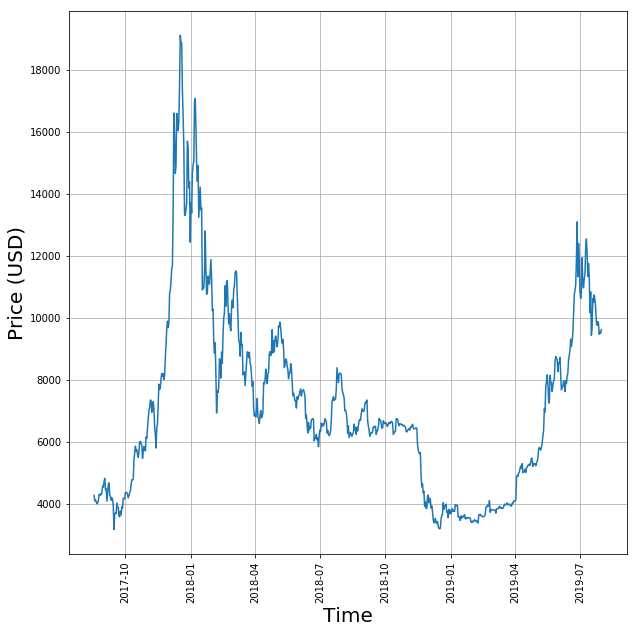

In [7]:
fig = plt.figure(figsize=(10,10))
plt.plot(data['close_time'],data['close'])
plt.xlabel('Time', size=20)
plt.ylabel('Price (USD)', size=20)
plt.xticks(rotation=90)
plt.grid()

This plot shows how the price of bitcoin has changed over the last two years. There isn't a lot of information on the plot yet, and it is difficult to make judgement on how the price might change just by looking at this plot

We need to check if there are missing values that might throw off the accuracy of our model

In [8]:
data.isnull().sum().sum()

0

Always good to see that there are no missing values! This was expected since the BTC market is open 24/7 and all the blockchain transactions are recorded carefully. 

# Technical Indicators

To understand technical indicators, please refer to Udacity's "Machine Learning for Trading" course via this link: https://classroom.udacity.com/courses/ud501

The first indicator is **momentum**

In [9]:
def calc_momentum(serie:pd.Series) :
    '''
    Gets a pandas Series and calculates the momentum of price
    OUTPUTS: a tuple of two series with the normalized and actual value of momentum
    '''
    momentum = serie - serie.shift(1)
    return 100*momentum / serie.shift(1), momentum

In [10]:
data['momentum'] , data['momentum_value']= calc_momentum(data['close'])

Another technical indicator that will be used for our analysis is **simple moving average (SMA)**

In [11]:
def calc_sma(serie: pd.Series, period:int) -> pd.Series:
    ''' calculates simple moving average'''
    sma = serie.rolling(period).mean()
    return sma

In [12]:
data['sma'] = calc_sma(data['close'], 5)

As a combination, momentum of SMA is also interesting to study

In [13]:
data['sma_momentum'] = data['sma']-data['sma'].shift(1)

Another indicator for price movement is deviation from moving average. A lot of traders believe that when there is a big deviation from the moving average, the price has to be corrected towards the moving average.

In [14]:
def calc_ma_dev(volume: pd.Series, period=5):
    '''
    Takes a pandas series as an input and returns
    the devation from moving average in the given series
    '''
    #calculate volume moving average
    volume_ma = volume.rolling(period).mean()
    devation = volume - volume_ma
    return devation/volume_ma

In [15]:
data['sma_dev'] = calc_ma_dev(data['sma'])

At this point we can look at our data and see how SMA changes over time

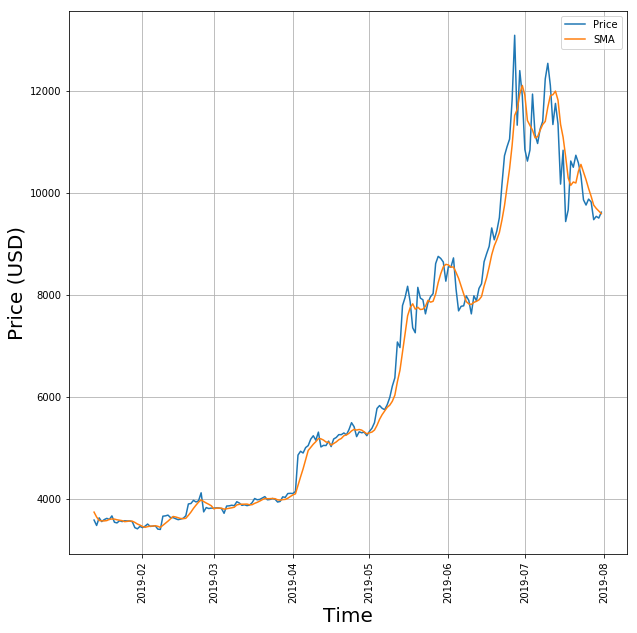

In [16]:
fig = plt.figure(figsize=(10,10))
plt.plot(data['close_time'].tail(200), data['close'].tail(200), label='Price')
plt.plot(data['close_time'].tail(200), data['sma'].tail(200), label='SMA')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.xlabel('Time', size=20)
plt.ylabel('Price (USD)', size=20)
plt.grid()

**Volatality** is also an important indicator, which is essentially the standard deviation of closing price over a certain period of time

In [17]:
def calc_volatality(series: pd.Series, period:int) -> pd.Series:
    '''calculates volatality or std of price over a certain period'''
    return series.rolling(period).std()

In [18]:
data['volatality'] = calc_volatality(data['close'], 5)

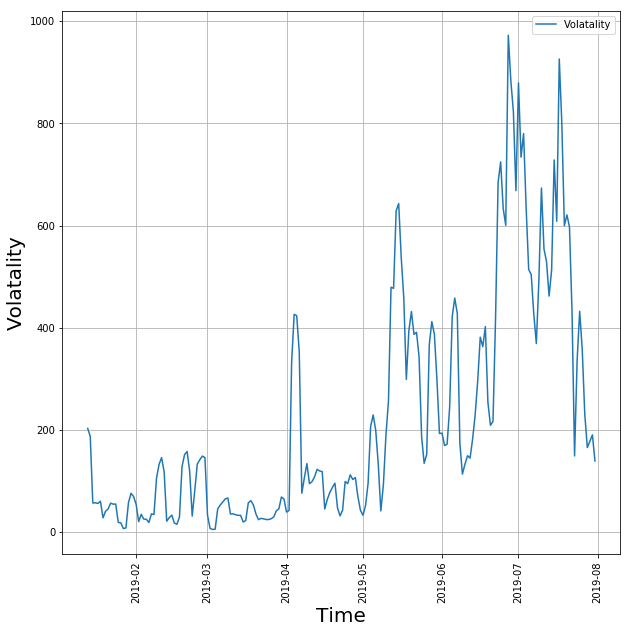

In [19]:
fig = plt.figure(figsize=(10,10))
plt.plot(data['close_time'].tail(200), data['volatality'].tail(200), label='Volatality')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.xlabel('Time', size=20)
plt.ylabel('Volatality', size=20)
plt.grid()

**Coefficient of variation (CV)** is defined as the ratio of the standard deviation to the mean : It shows the extent of variability in relation to the mean of the population

In [20]:
def calc_cv(volatality, sma):
    '''calculates coefficient of variability'''
    return volatality/sma

In [21]:
data['cv'] = calc_cv(data['volatality'], data['sma'])

We also need to calculate the **Sharpe ratio**, which is a measure that indicates the average return minus the risk-free return divided by the standard deviation of return on an investment. Sharpe ratio is used to help investors understand the return of an investment compared to its risk.

In [22]:
def calc_sharpe(momentum: pd.Series, period:int) -> pd.Series:
    '''takes in the daily returns (momentum) and returns Sharpe ratio'''
    # assuming that risk free return of any asset is zero over the period of study
    average_return = momentum.rolling(period).mean()
    std = momentum.rolling(period).std()
    return average_return/std

In [23]:
data['sharpe'] = calc_sharpe(data['momentum'], 5)

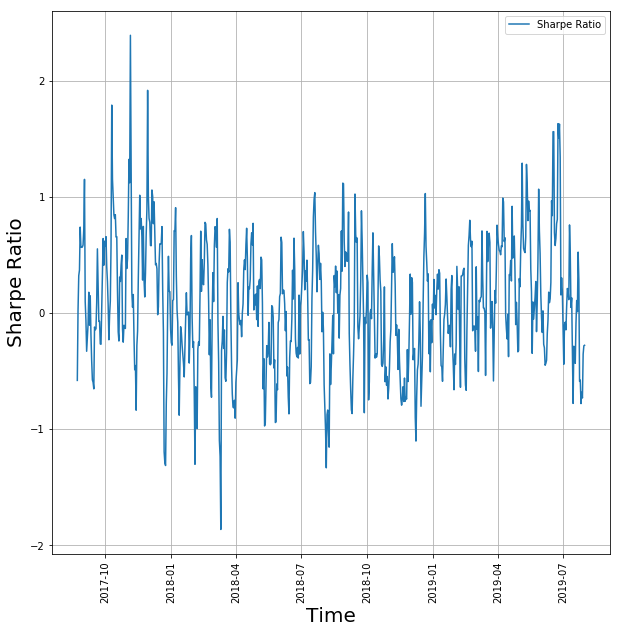

In [24]:
fig = plt.figure(figsize=(10,10))
plt.plot(data['close_time'].tail(1000), data['sharpe'].tail(1000), label='Sharpe Ratio')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.xlabel('Time', size=20)
plt.ylabel('Sharpe Ratio', size=20)
plt.grid()

This plot shows how Sharpe ratio has changed over time. Some traders only take the Sharpe ratio over one year of return. While that might be a good strategy, it will yield a single value for all trading days over the year. Our objective is to find the features that change with the market so that we can find possible correlations between the price and those features. For this reason, we have defined Sharpe ratio over a period of five days. 

#### Volume

Volume can be a great indicator given that it shows the amount of buy/sell pressure in the stock. However, using volume is tricky. Here is a plot indicating how the volume of trading of Bitcoin has changed in the last few months:

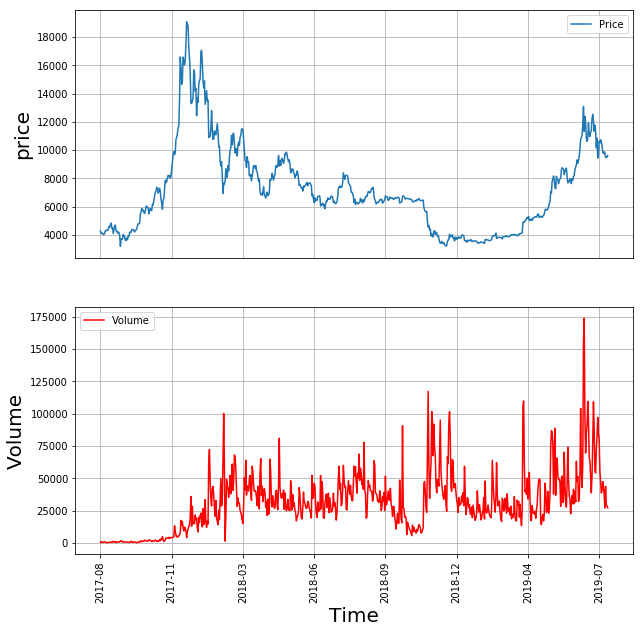

In [25]:
x=1000
fig = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(data['close_time'].tail(x), data['close'].tail(x), label = 'Price')
plt.legend(loc='best')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('price',size=20)
plt.xticks(data['close_time'][-x::int(x/10)], rotation=90)
plt.grid()

plt.subplot(2,1,2)
plt.plot(data['close_time'].tail(x), data['volume'].tail(x), label = 'Volume', color='red')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.ylabel('Volume',size=20)
plt.xlabel('Time', size=20)
plt.xticks(data['close_time'][-x::int(x/10)], rotation=90)
plt.grid()

The plot shows that the amount of interest in bitcoin has been increasing over the last few months. This clearly shows that the price doesn't necessarily have a direct relationship with volume, however, it sure looks like a spike in volume can cause significant changes in the price.  The plot below might be useful to further investigate

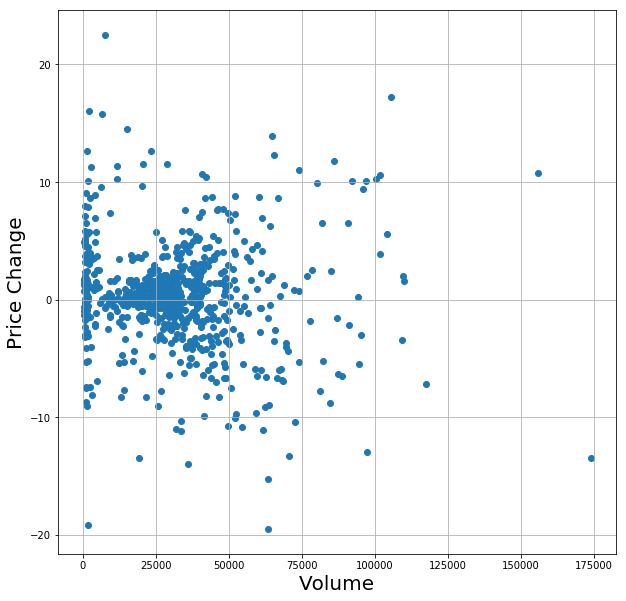

In [26]:
fig = plt.figure(figsize=(10,10))
plt.scatter(data['volume'], data['momentum'])
plt.ylabel('Price Change', size=20)
plt.xlabel('Volume',size=20)
plt.grid()

This is a very interesting plot. It looks like there are a bunch of point with really low volume, with relatively high changes in the price, whereas there are also some points where the volume is higher with various range of price changes. 

As you can see in the plots above, the volume of bitcoin trading really picked up starting from Dec 2017 and prior to that point, volume was an order of magnitude smaller. This means that in order to find a meaningful relationship between volume and price, we need to normalize the volume. On the other hand, if we normalize the value of volume over all the rows, we'll get tiny values for the period when bitcoin wasn't as popular as today, and relatively significant changes in that period would be neglected by the model due to small values. Let's see if we can cluster the values of volume with unsupervised learning and normalize the values of volume only in the corresponding cluster. We'll start by trying out Kmeans clustering:

In [27]:
#For Kmeans to be meaningful, we have to normalize the points over the whole range first
subsetdata = data[['volume','momentum']]
subsetdata = (subsetdata-subsetdata.min())/(subsetdata.max()-subsetdata.min())
subsetdata = subsetdata.dropna(axis=0)

In [28]:
subsetdata.head()

,volume,momentum
1,0.005596,0.366047
2,0.000882,0.482556
3,0.001376,0.433358
4,0.002670,0.423280
5,0.004253,0.478466


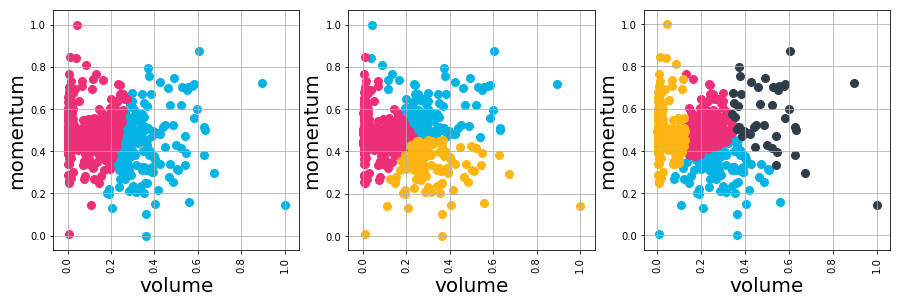

In [29]:
def plot_clusters(data: pd.DataFrame, n_clusters:int):
    '''
    Takes in a dataframe and a number of cluster
    does KNN for the specified number of clusters
    plots the clusters
    '''
    data = data.dropna(axis=0)
    model = KMeans(n_clusters) # instantiate a model with two centers
    preds = model.fit(data).predict(data)
    plot_colors = ['#02b3e4', '#ee2e76', '#ffb613', '#2e3d49']
    for k, col in zip(range(n_clusters), plot_colors[:n_clusters]):
        my_members = (preds == k)
        plt.scatter(data['volume'][my_members], data['momentum'][my_members], s = 64, c = col)

    plt.xlabel('volume',size=20)
    plt.ylabel('momentum',size=20)
    plt.xticks(rotation=90)
    plt.grid()
    
    
fig=plt.figure(figsize=(15,15))
plt.subplot(3,3,1)
plot_clusters(subsetdata, 2)
plt.subplot(3,3,2)
plot_clusters(subsetdata, 3)
plt.subplot(3,3,3)
plot_clusters(subsetdata, 4)

Looks like Kmeans doesn't capture the low/high volume clusters correctly. We'll try Gaussian Mixture Models

In [30]:
def do_gmm(subsetdata):
    '''
    Takes in a dataframe and fits a gaussian mixture model and plots the results
    Returns the predicted labels
    '''
    for n in range(2,5):
        subsetdata = subsetdata.dropna(axis=0)
        gmm = GaussianMixture(n_components=n).fit(subsetdata)

        gmm = gmm.fit(subsetdata)

        pred_gmm = gmm.predict(subsetdata)

        fig=plt.figure(figsize=(25,25))
        plt.subplot(4,4,n-1)
        plt.scatter(subsetdata['volume'], subsetdata['momentum'], c=pred_gmm, edgecolor='black',
                    lw=1.5, s=50, cmap=plt.get_cmap('viridis'))
        plt.xlabel('volume',size=10)
        plt.ylabel('momentum',size=10)
        plt.show()
    
    return pred_gmm

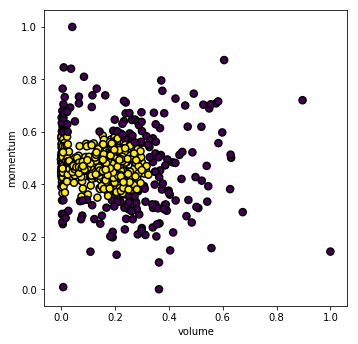

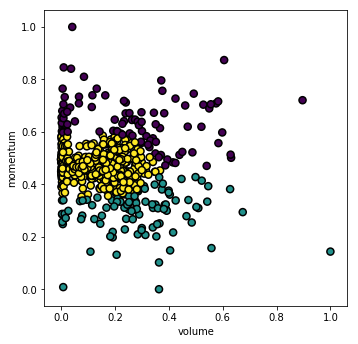

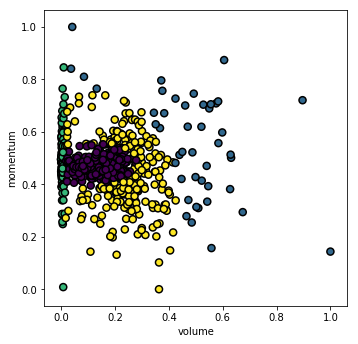

In [31]:
pred_gmm = do_gmm(subsetdata)


Looks like based on GMM, the reasonable number for cluster is 4, where one refers to low volume and a large range of volatality, one refers to moderate volumes and small changes in price, and two other clusters refer to relatively higher volatalities

Let's also look at how these points are spread on the price chart

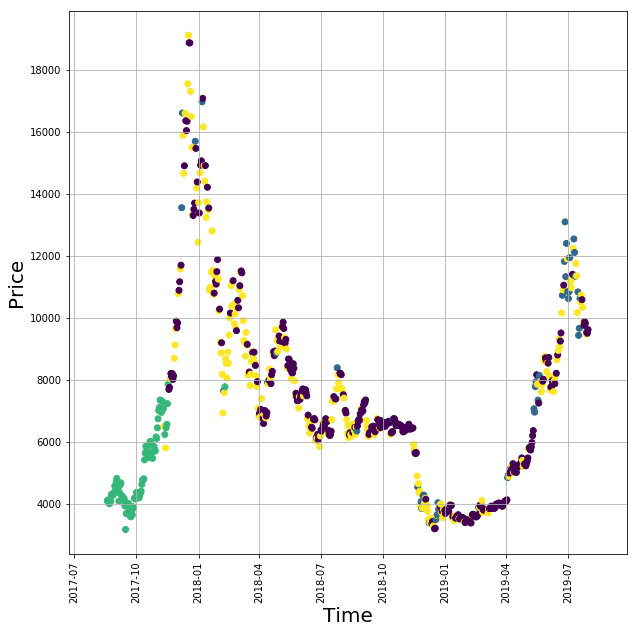

In [32]:
fig = plt.figure(figsize=(10,10))
plt.scatter(data['close_time'].iloc[1:], data['close'].iloc[1:], c=pred_gmm) #remember we dropped the first row in pred_gmm
plt.xticks(rotation=90)
plt.ylabel('Price',size=20)
plt.xlabel('Time',size=20)
plt.grid()
plt.show()

The plot shows that the low volume period prior to Dec 2017 has been correctly clustered together. However, the rest of the pints are spread across the time and mixed together.This is not exatly favorable since we need to detect significant changes in volume compared to the average for those days. For this reason, we will be looking at the moving average for the volume.

In [33]:
data['vma_dev'] = calc_ma_dev(data['volume'], period=14)

Let's see how volume deviation compares to volume and price

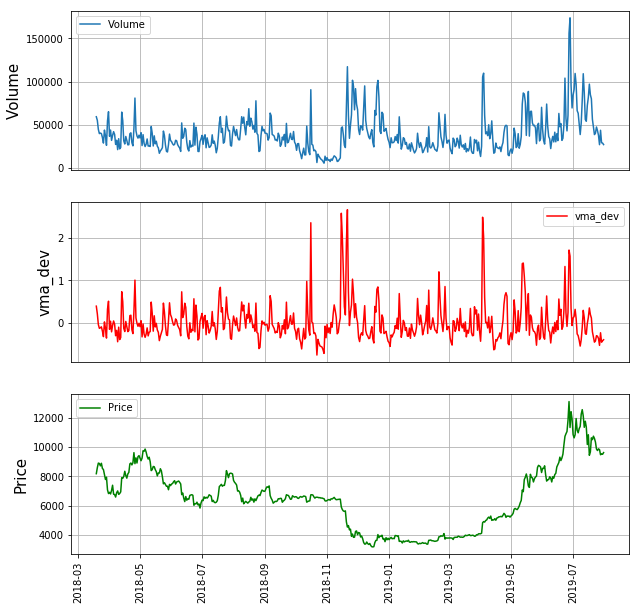

In [34]:
x=500
fig = plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(data['close_time'].tail(x), data['volume'].tail(x), label = 'Volume')
plt.legend(loc='best')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Volume',size=15)
plt.grid()

plt.subplot(3,1,2)
plt.plot(data['close_time'].tail(x), data['vma_dev'].tail(x), label = 'vma_dev', color='red')
plt.legend(loc='best')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('vma_dev',size=15)
plt.grid()

plt.subplot(3,1,3)
plt.plot(data['close_time'].tail(x), data['close'].tail(x), label = 'Price', color='green')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.ylabel('Price',size=15)
plt.grid()

#### Price Rejection

Other than close price, there are other information available about how the price has changed during a certain period. "High" and "Low" columns are especially interesting since they can point at price rejections at high or low values. For example, if the value for high column is a lot bigger than the value of close column, it means that the price had gone significantly higher and then dropped. This becomes vitally important to know when the close price of a row is very similar to the close price of the previous row, showing a steady price where in reality that is not the case. 

We'll calculate price rejections as well

In [35]:
def calc_price_rejections(high:pd.Series, low:pd.Series, close:pd.Series):
    '''calculates price rejections as a function of daily highs and lows and closing prices'''
    
    resistance_rejection = close - high
    support_rejection = close - low
    return resistance_rejection, support_rejection

In [36]:
data['r_rejection'], data['s_rejection'] = calc_price_rejections(data['high'], data['low'], data['close'])

#### Support and Resistance Levels

Analyzing support and resistance levels are generally a great way of predicting the future price. There are different methods of calculating support and resistance levels. For this study, we use pivot point over a certain period of time.
https://www.investopedia.com/terms/p/pivotpoint.asp

In [37]:
def calc_support_resistance(high:pd.Series, low:pd.Series, close:pd.Series, period:int):
    '''calculates support and resistance based on pivot points
    INPUTS: daily highs and lows as well as closing prices
    OUTPUTS: support and resistance levels'''
    min_low = low.rolling(period).min()
    max_high = high.rolling(period).max()
    mean_close = close.rolling(period).mean()
    
    pivot_point = (min_low + max_high + mean_close)/3
    resistance = 2*pivot_point - min_low
    support = 2*pivot_point - max_high
    
    return support, resistance

In [38]:
data['support'], data['resistance'] = calc_support_resistance(data['high'], data['low'], data['close'], 5)

Let's take a look at how support and resistance levels appear in a price chart

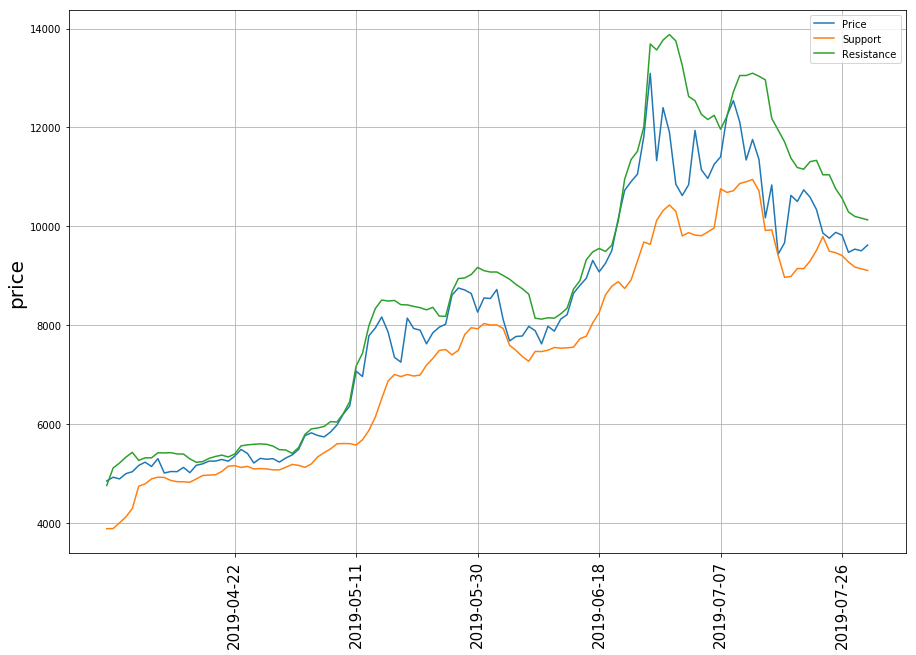

In [39]:
fig = plt.figure(figsize=(15,10))
plt.plot(data['close_time'].tail(120), data['close'].tail(120), label = 'Price')
plt.plot(data['close_time'].tail(120), data['support'].tail(120), label = 'Support')
plt.plot(data['close_time'].tail(120), data['resistance'].tail(120), label = 'Resistance')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.ylabel('price',size=20)
plt.xticks(data['close_time'][-100::19],size=15)

plt.grid()



**Notice** that the price is mostly within the area between the support and resistance level. on the occations that the price has exceeded the support or resistance levels, it has quickly re-adjusted itself. In this case, the support and resistance levels are very similar to Bollinger bands, which we'll discuss next

#### Bollinger bands

As indicated in the course, Bollinger bands can also indicate if the price of a stock/cryptocurrency is over-bought or over-sold. https://traderhq.com/ultimate-guide-to-bollinger-bands/

We'll include Bollinger bands in our studies as well

In [40]:
def calc_bollinger_bands(close:pd.Series, period=20):
    '''calculates Bollinger bands and return a tuple of lower band and upper band'''
    sma = close.rolling(period).mean()
    std = close.rolling(period).std()
    lower_band = sma - 2*std
    upper_band = sma + 2*std
    return lower_band, upper_band

In [41]:
data['bollinger_lower'], data['bollinger_upper'] = calc_bollinger_bands(data['close'])

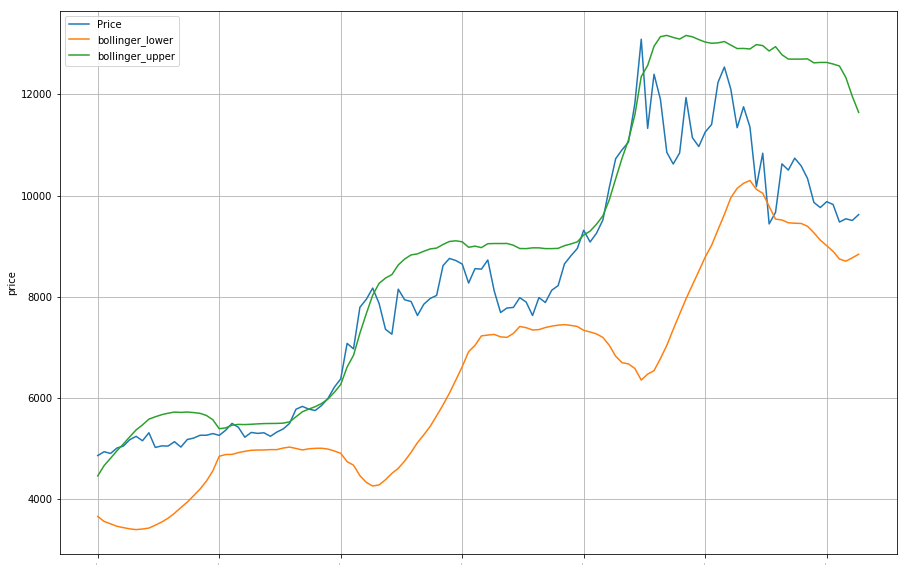

In [42]:
x=120
fig = plt.figure(figsize=(15,10))
plt.plot(data['close_time'].tail(x), data['close'].tail(x), label = 'Price')
plt.plot(data['close_time'].tail(x), data['bollinger_lower'].tail(x), label = 'bollinger_lower')
plt.plot(data['close_time'].tail(x), data['bollinger_upper'].tail(x), label = 'bollinger_upper')
plt.legend(loc='best')
plt.xticks(data['close_time'][-120::19],size=0,rotation=90)
plt.ylabel('price')
plt.grid()
plt.show()

As you can see in the plot, Bollinger bands are quite different from support and resistance levels. One huge difference is that if price has a sudden move upwards, the Bollinger bands will diverge since the standard deviation has increased. In this case, the price needs to have a massive downturn to reach the lower band, which in turn causes the lower band to move further down. However, in case of resistance and support, if the price jumps upwards, the new support level will also jump up, which makes more sense since the buying pressure will usually prevent the price from major corrections.
However, the idea is still the same. This means that traders generally tend to buy when the price is below the lower band and sell when the price is higher than the upper band

**Using Support, Resistance and Bollinder bands**

The value of support, resistance and the Bollinger bands don't offer a lot of value, rather it's the position of closing price within the chart relative to these values that might hint at future movements of the price. Hence, we build a custom metric called resistance score. 

Support score is essentially a metric indicating the closeness of the price to the support level (or lower Bollinger band)
A support score of 1 means the price is at the support level (thus theoretically ready to bounce back up) while a score of 0 indicates that the price is at the resistance level (due for possible correction)

Note that support score is not always between 0 and 1 and can have any value, however, it is very unlikely to observe large deviations from this interval

In [43]:
data['support_score'] = (data['resistance'] - data['close'])/(data['resistance'] - data['support'])

In [44]:
data['bollinger_score'] = (data['bollinger_upper'] - data['close'])/(data['bollinger_upper'] - data['bollinger_lower'])

#### Relative Stregth Index

Relative Strength Index (RSI) can be a powerful tool for understanding whether a stock/cryptocurrency is over-bought or over-sold, which will be included in our analysis

In [45]:
def calc_rsi(close:pd.Series, RSI_period=14):
    '''Takes a series of prices and calculates RSI'''
    percent_change, momentum = calc_momentum(close)
    limit = len(close)
    RSI = np.zeros(limit,)
    for i in range(RSI_period+1,limit):
        gains=[]
        losses=[]
        for j in range(0,RSI_period):
            if percent_change[i-j]>0:
                gains.append(percent_change[i-j])
            elif percent_change[i-j]<0:
                losses.append(abs(percent_change[i-j]))
        if (len(gains)!=0) & (len(losses)!=0):
            ave_gain = sum(gains)/len(gains)
            ave_loss = sum(losses)/len(losses)
            RSI[i,] = 100 - (100/(1+ave_gain/ave_loss))
        elif len(gains)==0:
            RSI[i,]=0
        elif len(losses)==0:
            RSI[i,]=100
    return RSI


In [46]:
data['rsi'] = calc_rsi(data['close'])

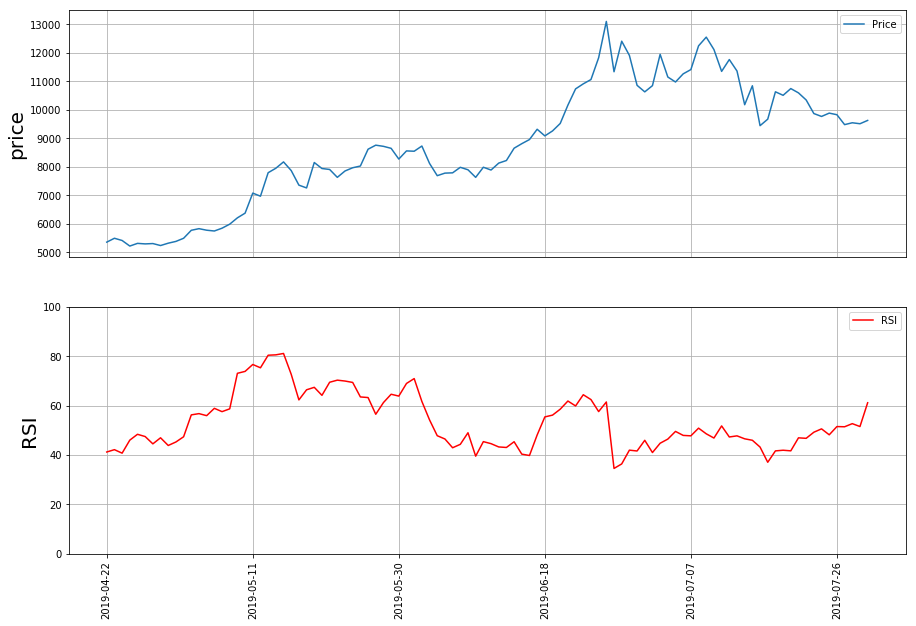

In [47]:
x=100
fig = plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(data['close_time'].tail(x), data['close'].tail(x), label = 'Price')
plt.legend(loc='best')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('price',size=20)
plt.xticks(data['close_time'][-100::19], rotation=90)
plt.grid()

plt.subplot(2,1,2)
plt.plot(data['close_time'].tail(x), data['rsi'].tail(x), label = 'RSI', color='red')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.ylim(0,100)
plt.ylabel('RSI',size=20)
plt.xticks(data['close_time'][-100::19], rotation=90)
plt.grid()

### Setting the Target Column

Note that we are trying to predict the price of the cryptocurrency, our target is basically the closing price at the next row. 

In [48]:
data['target_close'] = data['close'].shift(-1)

#### Dealing with Missing data

Since the missing data is an artifact of calculating moving averages with the rolling function, and the amount of mising data is very low, we should feel comfortable with dropping the rows with missing values. 

Filling the missing data with mean or mode is a big mistake for all the reasons we discussed above, especially when we were studying volume

In [49]:
data = data.dropna(axis=0)

In [50]:
data.head(5)

,open_time,open,high,low,close,volume,close_time,momentum,momentum_value,sma,...,r_rejection,s_rejection,support,resistance,bollinger_lower,bollinger_upper,support_score,bollinger_score,rsi,target_close
19,2017-09-05,4106.97,4484.99,3603.00,4366.47,1228.938157,2017-09-05 23:59:59.999,6.496411,266.36,4456.542,...,-118.52,763.47,3726.631333,5062.821333,3865.926101,4791.151899,0.521147,0.459004,45.195889,4619.77
20,2017-09-06,4366.49,4662.87,4335.26,4619.77,807.363726,2017-09-06 23:59:59.999,5.801025,253.30,4413.514,...,-43.10,284.51,3697.946000,5034.136000,3865.388264,4825.158736,0.310110,0.213998,48.517702,4691.61
21,2017-09-07,4619.77,4788.59,4438.19,4691.61,500.429975,2017-09-07 23:59:59.999,1.555056,71.84,4457.408,...,-96.98,253.42,3777.408667,4962.998667,3884.388457,4864.482543,0.228906,0.176384,45.737594,4282.80
22,2017-09-08,4691.66,4735.39,4028.93,4282.80,1132.255046,2017-09-08 23:59:59.999,-8.713640,-408.81,4412.152,...,-452.59,253.87,3747.238000,4932.828000,3901.861277,4861.291723,0.548274,0.602953,37.223203,4258.81
23,2017-09-09,4282.80,4426.62,4150.06,4258.81,658.782952,2017-09-09 23:59:59.999,-0.560148,-23.99,4443.892,...,-167.81,108.75,3768.398000,4953.988000,3926.921037,4853.483963,0.586356,0.641806,42.772093,4130.37


### Feature Selection

All the features that we have built so far have the potential to be included in the model. However, we need to do a lot of experiments to see which features meaningfully contribute to the accuracy of the model.

In [51]:
data.columns.values

array(['open_time', 'open', 'high', 'low', 'close', 'volume',
       'close_time', 'momentum', 'momentum_value', 'sma', 'sma_momentum',
       'sma_dev', 'volatality', 'cv', 'sharpe', 'vma_dev', 'r_rejection',
       's_rejection', 'support', 'resistance', 'bollinger_lower',
       'bollinger_upper', 'support_score', 'bollinger_score', 'rsi',
       'target_close'], dtype=object)

Of all these columns, anyone can be selected to be a feature but target_close column. 

In [52]:
possible_featurs = data.columns.values[:-1]

We'll start by a smaller subset of features

In [53]:
features_all = ['open', 'high', 'low', 'close', 'volume', 'momentum', 
                'momentum_value', 'sma', 'sma_momentum','sma_dev', 
                'volatality', 'cv', 'sharpe', 'vma_dev', 'r_rejection',
                's_rejection', 'support', 'resistance', 'bollinger_lower',
                'bollinger_upper', 'support_score', 'bollinger_score', 'rsi']

features_selection_1 = ['close','volume','momentum_value','sma_momentum','sma_dev',
                      'volatality','vma_dev','support_score','bollinger_score']

features_selection_2 = ['close','momentum_value','sma_momentum','sma_dev',
                      'vma_dev','support_score','bollinger_score']

features_selection_3 = ['close', 'momentum_value', 'sma_momentum', 'sma_dev', 
                        'vma_dev', 'support_score']


In [54]:
target = 'target_close'

### Training Deep Learning Models
Now that we have selected our features and identified our target, we should move on to training a model to predict prices.
I'll start with deep learning. For this purpose we'll be using keras library. We'll write a function that takes in a neural networks architecture and trains it on the training data and makes predictions with it, and compares different architectures in terms of their mean absolute error.

These models will be our baseline and we'll compare their performance

In [55]:
def train_predict_model(data: pd.DataFrame, features:list, epochs:int =1500, batch_size:int=50, verbose:int=0):

    '''
    INPUTS: data: a dataframe which containts features and targets
    features_selection: a list of selected features
    epochs: int, number of epochs for training NN
    batch_size: int, size of batch for training NN
    OUTPUTS:
    mae: mean absolute error of the model
    
    trains a deep learning algorithm and makes predictions for the price
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.15, random_state=42)
    print(80*'*', '\n', '\n', 'Building Neural Networks')
    
    # Defining the neural networks
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(len(features),)))
    model.add(Dropout(.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation='relu'))

    # Compiling the model
    model.compile(loss = 'mse', optimizer='adam', metrics=['mae'])
    
    # Fitting the model
    model.fit(X_train, y_train, epochs, batch_size, verbose)
    
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(1,-1)[0]
    
    y_pred_train = model.predict(X_train)
    y_pred_train = y_pred_train.reshape(1,-1)[0]
    # calculating mean absolute error
    print('Features are :', features)
    print('Epochs:',epochs)
    print('Batch Size:', batch_size)
    mae_test = (abs(y_pred - y_test)/y_test).mean()
    print('Mean Absolute Error on Testing set =', mae_test)
    mae_train = (abs(y_pred_train - y_train)/y_train).mean()
    print('Mean Absolute Error on Testing set =', mae_train)

    return mae_test

In [58]:
mae_models = {}
for features in [features_all, features_selection_1, features_selection_2, features_selection_3]:
    mae_models[len(features)] = {}
    for epochs in [2500, 3500]:
        mae_models[len(features)][epochs]={}
        for batch_size in [20, 50,75]:
            mae_test = train_predict_model(data, features, epochs, batch_size)
            mae_models[len(features)][epochs][batch_size] = mae_test

******************************************************************************** 
 
 Building Neural Networks
Features are : ['open', 'high', 'low', 'close', 'volume', 'momentum', 'momentum_value', 'sma', 'sma_momentum', 'sma_dev', 'volatality', 'cv', 'sharpe', 'vma_dev', 'r_rejection', 's_rejection', 'support', 'resistance', 'bollinger_lower', 'bollinger_upper', 'support_score', 'bollinger_score', 'rsi']
Epochs: 2500
Batch Size: 20
Mean Absolute Error on Testing set = 0.2040429560318509
Mean Absolute Error on Testing set = 0.1971644802774815
******************************************************************************** 
 
 Building Neural Networks
Features are : ['open', 'high', 'low', 'close', 'volume', 'momentum', 'momentum_value', 'sma', 'sma_momentum', 'sma_dev', 'volatality', 'cv', 'sharpe', 'vma_dev', 'r_rejection', 's_rejection', 'support', 'resistance', 'bollinger_lower', 'bollinger_upper', 'support_score', 'bollinger_score', 'rsi']
Epochs: 2500
Batch Size: 50
Mean Absolute 

Features are : ['close', 'momentum_value', 'sma_momentum', 'sma_dev', 'vma_dev', 'support_score']
Epochs: 2500
Batch Size: 50
Mean Absolute Error on Testing set = 0.12000268014838386
Mean Absolute Error on Testing set = 0.11760744500987616
******************************************************************************** 
 
 Building Neural Networks
Features are : ['close', 'momentum_value', 'sma_momentum', 'sma_dev', 'vma_dev', 'support_score']
Epochs: 2500
Batch Size: 75
Mean Absolute Error on Testing set = 0.09550149337963024
Mean Absolute Error on Testing set = 0.09334783989666462
******************************************************************************** 
 
 Building Neural Networks
Features are : ['close', 'momentum_value', 'sma_momentum', 'sma_dev', 'vma_dev', 'support_score']
Epochs: 3500
Batch Size: 20
Mean Absolute Error on Testing set = 0.03330548680332575
Mean Absolute Error on Testing set = 0.031649366255832784
***********************************************************

In [59]:
mae_models

{23: {2500: {20: 0.2040429560318509,
   50: 0.27561108770176584,
   75: 0.22310964171327197},
  3500: {20: 0.2690747776031246,
   50: 0.19714581856732877,
   75: 0.3011250581795194}},
 9: {2500: {20: 0.25897947478912,
   50: 0.21449325068033578,
   75: 0.2658978132217885},
  3500: {20: 0.40856308597783186,
   50: 0.22556510955752526,
   75: 0.17216228717567525}},
 7: {2500: {20: 0.03539845409351041,
   50: 0.10544871117826078,
   75: 0.0717722587206658},
  3500: {20: 0.1497622958509712,
   50: 0.1347492047983338,
   75: 0.11593677315808122}},
 6: {2500: {20: 0.177439420212643,
   50: 0.12000268014838386,
   75: 0.09550149337963024},
  3500: {20: 0.03330548680332575,
   50: 0.0684582563327253,
   75: 0.09809510784007876}}}

**Discussion**

It looks like fewer features have cause a higher accuracy. The mae_models now contains the mean absolute error of each of the deep learning models that we trained. The lowest error is for the model with 6 features, 2500 epochs and a batch size of 20. The minimum mean absolute error that we achieved was 3.3%.


Let's train machine learning models as well to compare their accuracy with deep learning models. We might be able to get a better accuracy with machine learning models

### Machine Learning Model Training

My top candidates for making this prediction are ensemble methods such as AdaBoost and RandomForest, as well as a linear regression model and a support vector regression model. We'll write a function that trains these models and makes prediction with them, does a grid search for them to select the best estimator

In [60]:
models =['AdaBoostRegressor', 'RandomForestRegressor', 'LinearRegression', 'SVR'] 

In [61]:
adaboost_params = {
    'learning_rate' : [0.1,0.01],
    'n_estimators' : [100,300,500]
}

In [62]:
randomforest_params = {
    'max_depth' : [2,5,10],
    'n_estimators' : [50,300,500],
    'max_leaf_nodes':[2,5,10]
    
}

In [63]:
linear_params = {
    'fit_intercept' : [True, False],
    'normalize' : [True, False]
}

In [64]:
svr_params = {
    # I did multiple grid searches on SVR and these are the values that were selected.
    # For saving time, I'm not including suboptimal parameters
    'kernel' : ['linear'],
    #'gamma' : [5,10]
    'epsilon' : [0.05]
}

In [65]:
def train_predict_ML(data: pd.DataFrame, models:list, features:list, target:str = 'target_close'):
    '''
    INPUTS: data: a dataframe containing the features and target
    features: a list of features for the model
    target: the column we want to predict
    models: a list of ML models to train
    
    loops through the list of models and traing them with the data and makes 
    predictions on the test set
    
    OUTPUTS: a list of mean absolute error of the models
    '''
    
    
    X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.15, random_state=42)
    
    stats = {}
    for model in models:
        if model == 'LinearRegression':
            print('Training Linear Regression Model...')
            cv = GridSearchCV(LinearRegression(), linear_params, cv=5)
            
        elif model == 'AdaBoostRegressor':
            cv = GridSearchCV(AdaBoostRegressor(), adaboost_params, cv=5)
            print('Grid Search for AdaBoost...')
            

        elif model == 'RandomForestRegressor':
            cv = GridSearchCV(RandomForestRegressor(random_state=42), randomforest_params, cv=5)
            print('Grid Search for RandomForest...')
         
        
        elif model == 'SVR':
            cv = GridSearchCV(SVR(), svr_params, cv=5)
            
            print('Grid Search for SVR...')    
        
        else:
            continue

            
            
            
        cv.fit(X_train, y_train)
        
        y_pred = cv.predict(X_test)
        y_pred_train = cv.predict(X_train)
        mae_test = (abs(y_pred-y_test)/y_pred).mean()
        mae_train = (abs(y_pred_train-y_train)/y_pred_train).mean()
        
        print(model, 'training and testing mean absolute errors are:', mae_train, mae_test)
        stats[model] = [mae_test,mae_train]
        

        print(cv.best_estimator_)
        print(80*'*','\n')
    
    return stats, y_pred

From our experience with deep learning model, we know that feature_selection_3 is the best set of features we can use.

In [66]:
mae_list, y_pred = train_predict_ML(data, models, features_selection_3, target)


Grid Search for AdaBoost...
AdaBoostRegressor training and testing mean absolute errors are: 0.04008602482961286 0.0451922876102074
AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='linear',
         n_estimators=300, random_state=None)
******************************************************************************** 

Grid Search for RandomForest...
RandomForestRegressor training and testing mean absolute errors are: 0.04002523369727335 0.04854244875663497
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=10,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
******************************************************************************** 

Training Linear Regression Model...
LinearRegression training 

It looks like the minimum error for both testing and training subsets, belongs to SVR which is 3.04%. So despite the fact that this model is extremely slow, we will be selecting this model as a baseline

### Conclusion

In this project we looked at historical prices of bitcoin, built the features for technical analysis that were taught in the Udacity's course "Machine Learning for Trading", did unsupervised learning to understand how volume and momentum clusters have formed, and finally built deep learning and machine learning models to predict the price for the next trading day. 

For each model, we did a parametric study and feature selection to examine how each of them impact the accuracy of the model. mean absolute error was selected as the metric for accuracy since it can tell us by how many percentage points our prediction will be off. 

The best model for predicting the price was SVR with a linear kernel and epsilon of 0.05. This model can be used for further predictions on the price



We observed that when the number of features were narrowed down, the mean absolute error of the models dropped significantly. This points at the fact that some of the features that were built, and are used by traders, are not generally a good indicator of future price movements. 
However, This doesn't mean that there is no value in examining the technical indicators. it only means that they cannot be absolutely reliable on their own and traders should look at other sources of information, especially fundamental analysis, which is out of the scope for this project.